# Keras Classification

<span class="girk">We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.</span>

---
---

## Import  libraries & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Exploratory Data Analysis and Visualization

In [4]:
# !pip install pandasgui

In [5]:
# from pandasgui import show

# gui = show(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
df.shape

(10000, 13)

In [8]:
df.isnull().sum().any()

False

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.000,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


<AxesSubplot:>

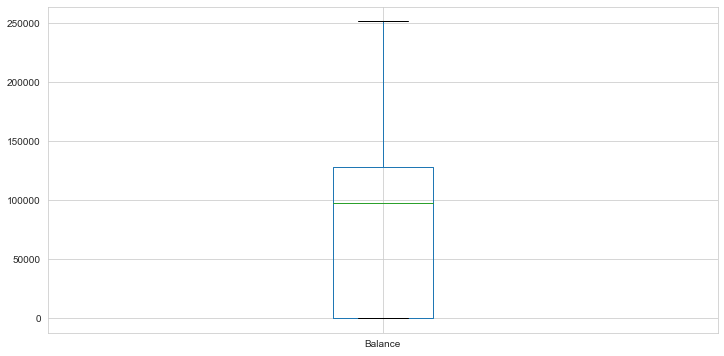

In [11]:
df.Balance.plot(kind="box")

In [12]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


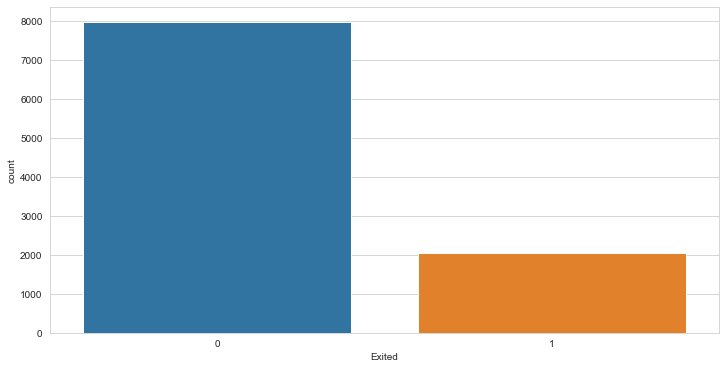

In [13]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

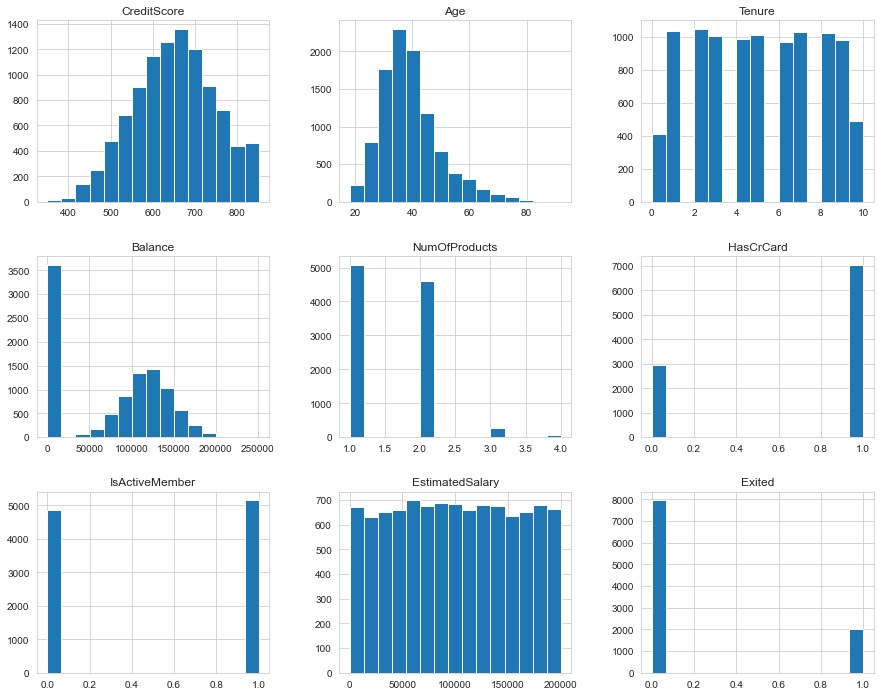

In [14]:
df.hist(figsize=(15, 12), bins=15);


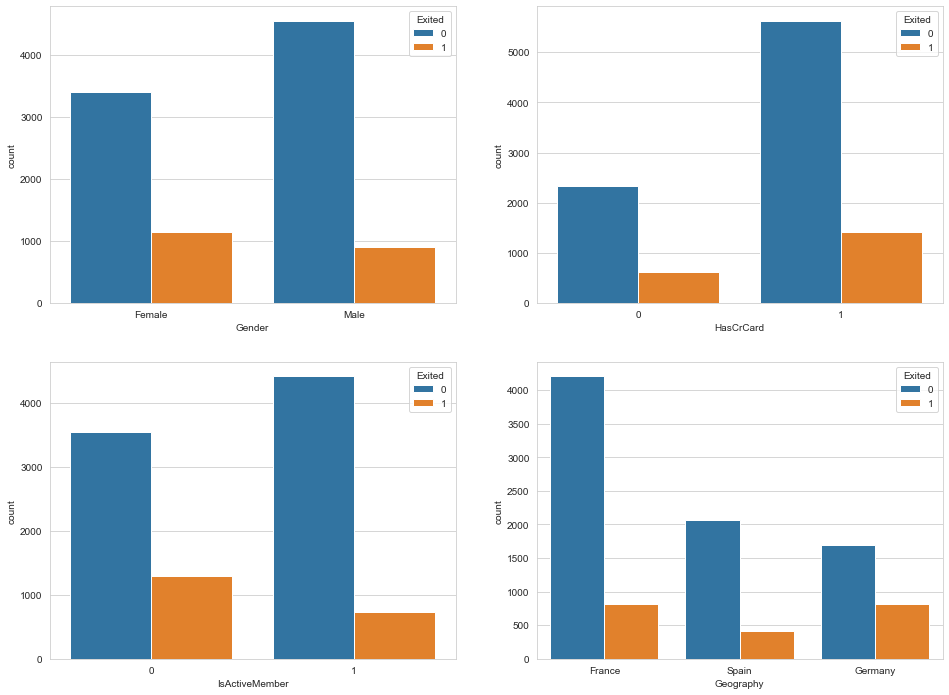

In [15]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [16]:
df.groupby("Age")["Exited"].value_counts()


Age  Exited
18   0         20
     1          2
19   0         26
     1          1
20   0         38
               ..
84   0          1
     1          1
85   0          1
88   0          1
92   0          2
Name: Exited, Length: 128, dtype: int64

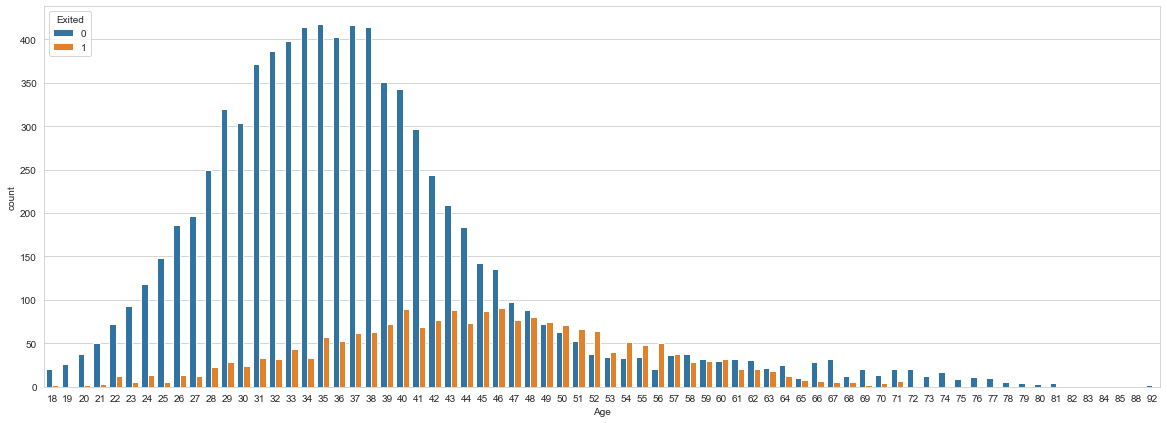

In [17]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [18]:
df.CreditScore.describe()

count   10000.000
mean      650.529
std        96.653
min       350.000
25%       584.000
50%       652.000
75%       718.000
max       850.000
Name: CreditScore, dtype: float64

In [19]:
def credit_transformer(x, y):
    if x < 584 and y == 0:
        return 0
    if x < 584 and y == 1:
        return 1
    if 584 < x < 718 and y == 0:
        return 2
    if 584 < x < 718 and y == 1:
        return 3
    else:
        return 4

In [20]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 1, 2, 4, 3, 4, 1, 0, 3]

In [21]:
set(customer_value)

{0, 1, 2, 3, 4}

In [22]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,1


In [23]:
df.insert(10, "customer_value", customer_value)

In [24]:
df.customer_value

RowNumber
1        3
2        2
3        1
4        2
5        4
        ..
9996     4
9997     1
9998     2
9999     4
10000    4
Name: customer_value, Length: 10000, dtype: int64

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

result = encoder.fit_transform(df.customer_value.values.reshape(-1, 1))
print(result)


df.customer_value = result
df.customer_value

In [25]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited
RowNumber,,,,,,,,,,,,
1,619,France,Female,42,2,0.000,1,1,1,101348.880,3,1
2,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,2,0
3,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,1
4,699,France,Female,39,1,0.000,2,0,0,93826.630,2,0
5,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.000,2,1,0,96270.640,4,0
9997,516,France,Male,35,10,57369.610,1,1,1,101699.770,1,0
9998,709,France,Female,36,7,0.000,1,0,1,42085.580,2,1


<AxesSubplot:>

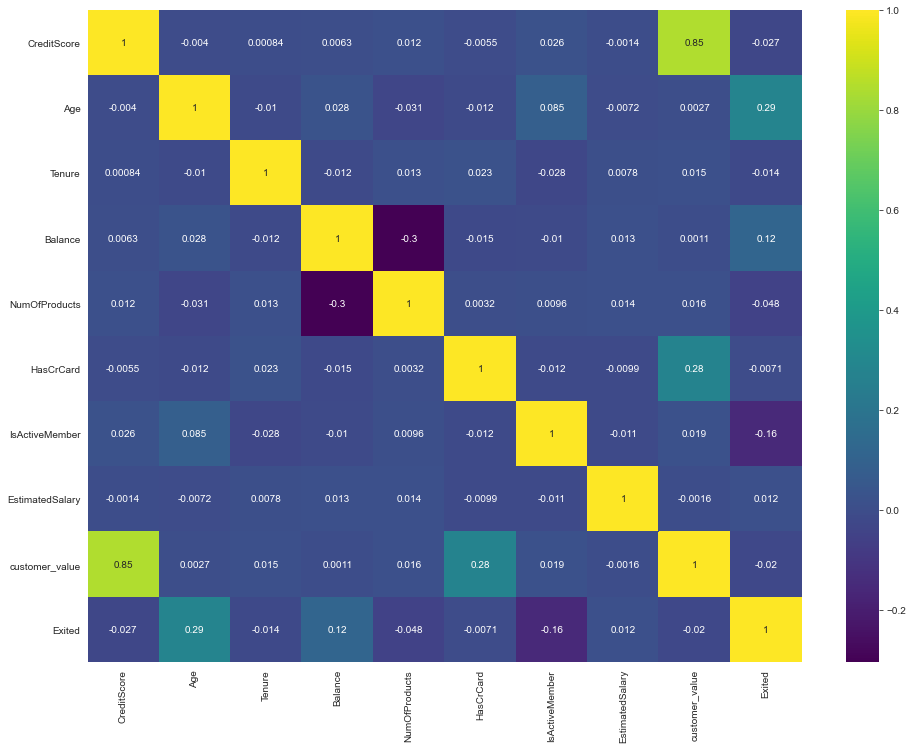

In [26]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

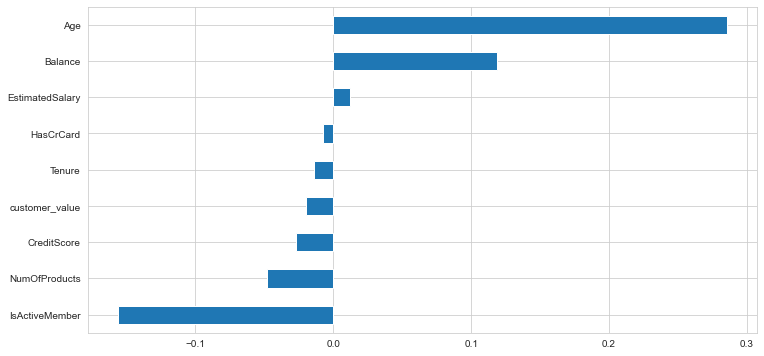

In [27]:
df.corr()['Exited'][:-1].sort_values().plot.barh();

In [28]:
df = pd.get_dummies(df)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,,,
1,619,42,2,0.000,1,1,1,101348.880,3,1,1,0,0,1,0
2,608,41,1,83807.860,1,0,1,112542.580,2,0,0,0,1,1,0
3,502,42,8,159660.800,3,1,0,113931.570,1,1,1,0,0,1,0
4,699,39,1,0.000,2,0,0,93826.630,2,0,1,0,0,1,0
5,850,43,2,125510.820,1,1,1,79084.100,4,0,0,0,1,1,0


## Preprocessing of Data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [30]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=42)


In [31]:
scaler = MinMaxScaler()


In [32]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

<span class="mark">How many hidden layers should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
How many hidden units should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
What is genetic algorithm? : https://www.researchgate.net/post/What_is_genetic_algorithm1
Genetic algorithm + neural networks: http://francky.me/doc/mrf2011-HEC-ISIR-ENS_en.pdf (chapter 2.2)</span>

### without class_weigth

In [33]:
model = Sequential()

model.add(Dense(30, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [34]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [35]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=500,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/500
64/64 [==============================] - 3s 17ms/step - loss: 0.8839 - recall: 0.7022 - val_loss: 0.6101 - val_recall: 0.0110
Epoch 2/500
64/64 [==============================] - 0s 6ms/step - loss: 0.6168 - recall: 0.1768 - val_loss: 0.5250 - val_recall: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5777 - recall: 0.0793 - val_loss: 0.5059 - val_recall: 0.0000e+00
Epoch 4/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5566 - recall: 0.0345 - val_loss: 0.4949 - val_recall: 0.0000e+00
Epoch 5/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5466 - recall: 0.0242 - val_loss: 0.4873 - val_recall: 0.0000e+00
Epoch 6/500
64/64 [==============================] - 0s 6ms/step - loss: 0.5378 - recall: 0.0200 - val_loss: 0.4813 - val_recall: 0.0000e+00
Epoch 7/500
64/64 [==============================] - 0s 7ms/step - loss: 0.5273 - recall: 0.0182 - val_loss: 0.4748 - val_recall: 0.0000e+00
Epoch 8/500
64/6

64/64 [==============================] - 0s 6ms/step - loss: 0.3999 - recall: 0.2912 - val_loss: 0.3292 - val_recall: 0.4420
Epoch 60/500
64/64 [==============================] - 0s 6ms/step - loss: 0.4036 - recall: 0.2857 - val_loss: 0.3350 - val_recall: 0.4365
Epoch 61/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3987 - recall: 0.3015 - val_loss: 0.3308 - val_recall: 0.4475
Epoch 62/500
64/64 [==============================] - 0s 7ms/step - loss: 0.4028 - recall: 0.2972 - val_loss: 0.3318 - val_recall: 0.4254
Epoch 63/500
64/64 [==============================] - 0s 7ms/step - loss: 0.4054 - recall: 0.2833 - val_loss: 0.3314 - val_recall: 0.4254
Epoch 64/500
64/64 [==============================] - 0s 6ms/step - loss: 0.4011 - recall: 0.2936 - val_loss: 0.3293 - val_recall: 0.4420
Epoch 65/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3980 - recall: 0.3063 - val_loss: 0.3294 - val_recall: 0.4420
Epoch 66/500
64/64 [===========================

64/64 [==============================] - 0s 7ms/step - loss: 0.3940 - recall: 0.2960 - val_loss: 0.3185 - val_recall: 0.4365
Epoch 119/500
64/64 [==============================] - 0s 7ms/step - loss: 0.3895 - recall: 0.3039 - val_loss: 0.3181 - val_recall: 0.4475
Epoch 120/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3889 - recall: 0.3214 - val_loss: 0.3188 - val_recall: 0.4530
Epoch 121/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3951 - recall: 0.3075 - val_loss: 0.3175 - val_recall: 0.4586
Epoch 122/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3914 - recall: 0.3105 - val_loss: 0.3200 - val_recall: 0.4254
Epoch 123/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3926 - recall: 0.3075 - val_loss: 0.3197 - val_recall: 0.4420
Epoch 124/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3890 - recall: 0.3111 - val_loss: 0.3154 - val_recall: 0.4309
Epoch 125/500
64/64 [====================

64/64 [==============================] - 0s 6ms/step - loss: 0.3817 - recall: 0.3384 - val_loss: 0.3109 - val_recall: 0.4696
Epoch 178/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3809 - recall: 0.3275 - val_loss: 0.3087 - val_recall: 0.4807
Epoch 179/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3814 - recall: 0.3378 - val_loss: 0.3103 - val_recall: 0.4972
Epoch 180/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3810 - recall: 0.3517 - val_loss: 0.3120 - val_recall: 0.4751
Epoch 181/500
64/64 [==============================] - 0s 7ms/step - loss: 0.3828 - recall: 0.3378 - val_loss: 0.3118 - val_recall: 0.4365
Epoch 182/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3855 - recall: 0.3287 - val_loss: 0.3077 - val_recall: 0.5138
Epoch 183/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3830 - recall: 0.3523 - val_loss: 0.3077 - val_recall: 0.5028
Epoch 184/500
64/64 [====================

64/64 [==============================] - 0s 6ms/step - loss: 0.3831 - recall: 0.3305 - val_loss: 0.3104 - val_recall: 0.4862
Epoch 237/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3823 - recall: 0.3257 - val_loss: 0.3101 - val_recall: 0.4530
Epoch 238/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3823 - recall: 0.3287 - val_loss: 0.3115 - val_recall: 0.4862
Epoch 239/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3796 - recall: 0.3438 - val_loss: 0.3113 - val_recall: 0.4862
Epoch 240/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3845 - recall: 0.3323 - val_loss: 0.3089 - val_recall: 0.4917
Epoch 241/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3785 - recall: 0.3584 - val_loss: 0.3092 - val_recall: 0.4475
Epoch 242/500
64/64 [==============================] - 0s 6ms/step - loss: 0.3805 - recall: 0.3487 - val_loss: 0.3117 - val_recall: 0.4696
Epoch 243/500
64/64 [====================

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                450       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

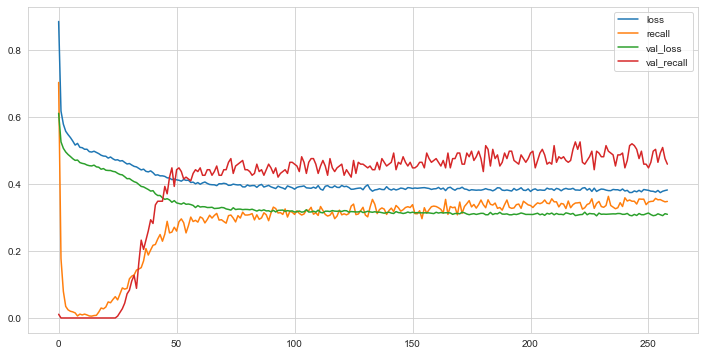

In [37]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [38]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
219,0.381,0.343,0.305,0.525
221,0.381,0.344,0.308,0.525
243,0.374,0.348,0.305,0.519
181,0.386,0.329,0.308,0.514
210,0.380,0.346,0.308,0.514
232,0.381,0.335,0.309,0.514
242,0.374,0.352,0.306,0.514
244,0.379,0.348,0.309,0.514
256,0.378,0.349,0.305,0.508
182,0.383,0.352,0.308,0.503


In [39]:
loss_df

,loss,recall,val_loss,val_recall
0,0.884,0.702,0.610,0.011
1,0.617,0.177,0.525,0.000
2,0.578,0.079,0.506,0.000
3,0.557,0.035,0.495,0.000
4,0.547,0.024,0.487,0.000
...,...,...,...,...
254,0.380,0.352,0.311,0.464
255,0.374,0.353,0.308,0.492
256,0.378,0.349,0.305,0.508
257,0.380,0.346,0.311,0.475


In [42]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[781  15]
 [130  74]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       796
           1       0.83      0.36      0.51       204

    accuracy                           0.85      1000
   macro avg       0.84      0.67      0.71      1000
weighted avg       0.85      0.85      0.83      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

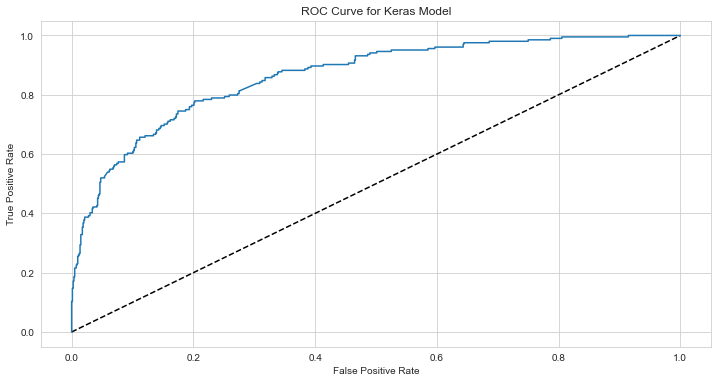

In [43]:
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [44]:
average_precision_score(y_test, y_pred_proba)

0.684255053352643

### with class_weigth

In [45]:
model_weighted = Sequential()

model_weighted.add(Dense(30, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(15, activation="relu"))
model_weighted.add(Dropout(0.5))
model_weighted.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model_weighted.compile(optimizer=opt, 
                       loss="binary_crossentropy",
                       metrics=["Recall"])

In [46]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=30)

In [47]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                   classes=np.unique(y_train),
                                                   y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [48]:
model_weighted.fit(x=X_train,
                   y=y_train,
                   validation_split=.1,
                   batch_size=128,
                   epochs=200,
                   verbose=1,
                   callbacks=[early_stop],
                   class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 4s 20ms/step - loss: 0.7406 - recall: 0.3015 - val_loss: 0.6761 - val_recall: 0.6188
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6870 - recall: 0.4818 - val_loss: 0.6693 - val_recall: 0.6022
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 0.6836 - recall: 0.5236 - val_loss: 0.6666 - val_recall: 0.6243
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 0.6748 - recall: 0.5738 - val_loss: 0.6615 - val_recall: 0.6575
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 0.6730 - recall: 0.6174 - val_loss: 0.6585 - val_recall: 0.6740
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 0.6661 - recall: 0.6138 - val_loss: 0.6666 - val_recall: 0.7514
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 0.6612 - recall: 0.6489 - val_loss: 0.6495 - val_recall: 0.7238
Epoch 8/200
64/64 [=====================

64/64 [==============================] - 0s 5ms/step - loss: 0.5413 - recall: 0.7203 - val_loss: 0.4853 - val_recall: 0.8232
Epoch 61/200
64/64 [==============================] - 0s 5ms/step - loss: 0.5370 - recall: 0.7300 - val_loss: 0.4696 - val_recall: 0.8177
Epoch 62/200
64/64 [==============================] - 0s 5ms/step - loss: 0.5362 - recall: 0.7203 - val_loss: 0.5002 - val_recall: 0.8398
Epoch 63/200
64/64 [==============================] - 0s 5ms/step - loss: 0.5347 - recall: 0.7452 - val_loss: 0.4550 - val_recall: 0.8066
Epoch 64/200
64/64 [==============================] - 0s 5ms/step - loss: 0.5337 - recall: 0.7246 - val_loss: 0.4623 - val_recall: 0.8066
Epoch 65/200
64/64 [==============================] - 0s 5ms/step - loss: 0.5358 - recall: 0.7318 - val_loss: 0.4666 - val_recall: 0.8232
Epoch 66/200
64/64 [==============================] - 0s 6ms/step - loss: 0.5356 - recall: 0.7300 - val_loss: 0.4830 - val_recall: 0.8343
Epoch 67/200
64/64 [===========================

<AxesSubplot:>

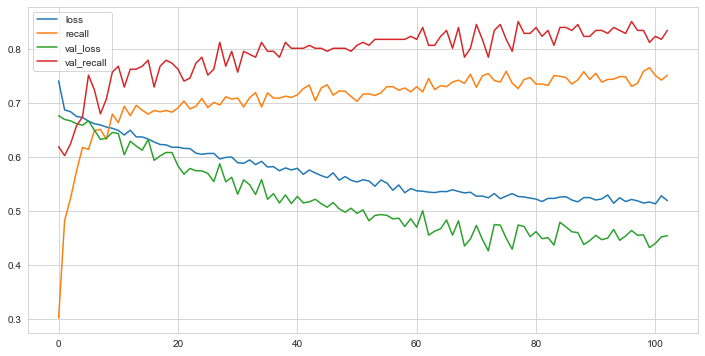

In [49]:
loss_df = pd.DataFrame(model_weighted.history.history)
loss_df.plot()

In [50]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
77,0.527,0.726,0.474,0.851
96,0.521,0.731,0.464,0.851
70,0.527,0.729,0.473,0.845
74,0.522,0.738,0.474,0.845
87,0.517,0.743,0.460,0.845
61,0.536,0.720,0.500,0.840
67,0.536,0.742,0.482,0.840
80,0.522,0.735,0.461,0.840
84,0.525,0.749,0.479,0.840
85,0.526,0.747,0.470,0.840


In [51]:
loss_df 

,loss,recall,val_loss,val_recall
0,0.741,0.301,0.676,0.619
1,0.687,0.482,0.669,0.602
2,0.684,0.524,0.667,0.624
3,0.675,0.574,0.661,0.657
4,0.673,0.617,0.658,0.674
...,...,...,...,...
98,0.514,0.758,0.455,0.834
99,0.516,0.765,0.432,0.812
100,0.513,0.751,0.440,0.823
101,0.528,0.742,0.452,0.818


In [52]:
y_test_pred = (model_weighted.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[602 194]
 [ 47 157]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.83       796
           1       0.45      0.77      0.57       204

    accuracy                           0.76      1000
   macro avg       0.69      0.76      0.70      1000
weighted avg       0.83      0.76      0.78      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

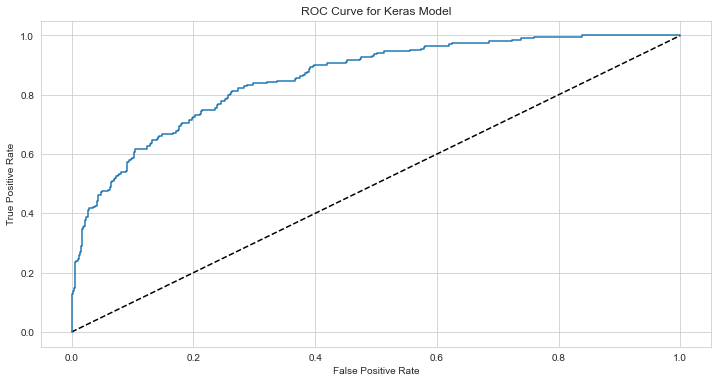

In [53]:
y_pred_proba = model_weighted.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [54]:
average_precision_score(y_test, y_pred_proba)

0.666752195562292

## GridSearchCV

In [55]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [56]:
def build_classifier(optimizer):
    
    classifier = Sequential()
    classifier.add(Dense(30, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(15, activation="relu"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(1, activation="sigmoid"))
    
    classifier.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [57]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [58]:
classifier = KerasClassifier(build_fn=build_classifier, epochs=150)
parameters = {'batch_size': [128, 256],
              'optimizer': [Adam, 'rmsprop', "SGD", "adagrad", "adadelta"]}

grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train, y_train, class_weight=class_weights)

Epoch 1/150
36/36 [==============================] - 3s 10ms/step - loss: 0.7387 - recall: 0.4544
Epoch 2/150
36/36 [==============================] - 0s 6ms/step - loss: 0.7053 - recall: 0.4201
Epoch 3/150
36/36 [==============================] - 0s 6ms/step - loss: 0.6911 - recall: 0.4768
Epoch 4/150
36/36 [==============================] - 0s 7ms/step - loss: 0.6802 - recall: 0.5161
Epoch 5/150
36/36 [==============================] - 0s 6ms/step - loss: 0.6779 - recall: 0.5477
Epoch 6/150
36/36 [==============================] - 0s 6ms/step - loss: 0.6686 - recall: 0.6094
Epoch 7/150
36/36 [==============================] - 0s 5ms/step - loss: 0.6694 - recall: 0.5930
Epoch 8/150
36/36 [==============================] - 0s 5ms/step - loss: 0.6626 - recall: 0.6159
Epoch 9/150
36/36 [==============================] - 0s 5ms/step - loss: 0.6624 - recall: 0.6154
Epoch 10/150
36/36 [==============================] - 0s 5ms/step - loss: 0.6593 - recall: 0.6438
Epoch 11/150
36/36 [========

36/36 [==============================] - 0s 7ms/step - loss: 0.5342 - recall: 0.7190
Epoch 85/150
36/36 [==============================] - 0s 8ms/step - loss: 0.5329 - recall: 0.7021
Epoch 86/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5326 - recall: 0.7147
Epoch 87/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5330 - recall: 0.7010
Epoch 88/150
36/36 [==============================] - 0s 5ms/step - loss: 0.5344 - recall: 0.7043
Epoch 89/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5220 - recall: 0.7349
Epoch 90/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5255 - recall: 0.7027
Epoch 91/150
36/36 [==============================] - 0s 7ms/step - loss: 0.5313 - recall: 0.7021
Epoch 92/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5341 - recall: 0.7038
Epoch 93/150
36/36 [==============================] - 0s 6ms/step - loss: 0.5249 - recall: 0.7218
Epoch 94/150
36/36 [=============

In [59]:
grid_model.best_score_

0.7213540467569709

In [60]:
grid_model.best_params_

{'batch_size': 256, 'optimizer': 'rmsprop'}

In [61]:
y_test_pred = (grid_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[595 201]
 [ 42 162]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       796
           1       0.45      0.79      0.57       204

    accuracy                           0.76      1000
   macro avg       0.69      0.77      0.70      1000
weighted avg       0.83      0.76      0.78      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

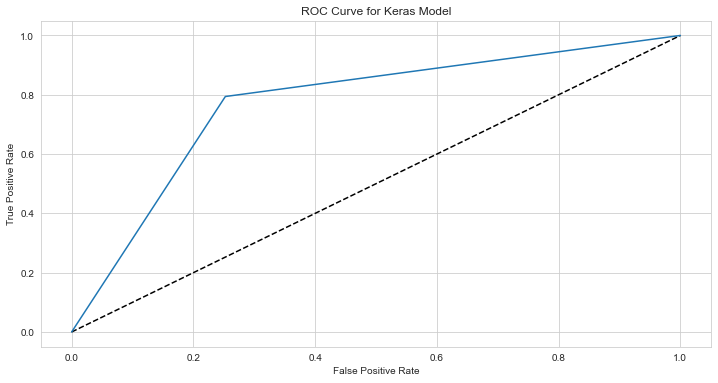

In [62]:
y_pred_proba = grid_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [63]:
average_precision_score(y_test, y_pred_proba)

0.39639961108410304

## Final Model and Model Deployment

In [64]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [65]:
final_model = Sequential()


final_model.add(Dense(30, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(15, activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(1, activation="sigmoid"))

final_model.compile(optimizer="rmsprop",
                    loss="binary_crossentropy",
                    metrics=["Recall"])

final_model.fit(x=X_train,
                y=y_train,
                validation_data=(X_test, y_test),
                callbacks=[early_stop],
                batch_size=128,
                epochs=200,
                verbose=1,
                class_weight=class_weights)

Epoch 1/200
71/71 [==============================] - 4s 20ms/step - loss: 0.6983 - recall: 0.5947 - val_loss: 0.6844 - val_recall: 0.5686
Epoch 2/200
71/71 [==============================] - 1s 7ms/step - loss: 0.6881 - recall: 0.5210 - val_loss: 0.6658 - val_recall: 0.4020
Epoch 3/200
71/71 [==============================] - 0s 6ms/step - loss: 0.6801 - recall: 0.5123 - val_loss: 0.6667 - val_recall: 0.5196
Epoch 4/200
71/71 [==============================] - 0s 5ms/step - loss: 0.6745 - recall: 0.5652 - val_loss: 0.6562 - val_recall: 0.5147
Epoch 5/200
71/71 [==============================] - 0s 5ms/step - loss: 0.6614 - recall: 0.5892 - val_loss: 0.6438 - val_recall: 0.5343
Epoch 6/200
71/71 [==============================] - 0s 5ms/step - loss: 0.6617 - recall: 0.5908 - val_loss: 0.6258 - val_recall: 0.5000
Epoch 7/200
71/71 [==============================] - 0s 5ms/step - loss: 0.6556 - recall: 0.6176 - val_loss: 0.6316 - val_recall: 0.5392
Epoch 8/200
71/71 [=====================

71/71 [==============================] - 0s 6ms/step - loss: 0.5461 - recall: 0.6732 - val_loss: 0.5097 - val_recall: 0.6912
Epoch 61/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5425 - recall: 0.6618 - val_loss: 0.5072 - val_recall: 0.6961
Epoch 62/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5422 - recall: 0.6792 - val_loss: 0.4956 - val_recall: 0.6618
Epoch 63/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5384 - recall: 0.6705 - val_loss: 0.5083 - val_recall: 0.6912
Epoch 64/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5450 - recall: 0.6699 - val_loss: 0.5015 - val_recall: 0.6765
Epoch 65/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5466 - recall: 0.6607 - val_loss: 0.5267 - val_recall: 0.7157
Epoch 66/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5352 - recall: 0.6918 - val_loss: 0.4919 - val_recall: 0.6667
Epoch 67/200
71/71 [===========================

71/71 [==============================] - 0s 6ms/step - loss: 0.5250 - recall: 0.6732 - val_loss: 0.4966 - val_recall: 0.7010
Epoch 120/200
71/71 [==============================] - 0s 6ms/step - loss: 0.5286 - recall: 0.6787 - val_loss: 0.4950 - val_recall: 0.7108
Epoch 121/200
71/71 [==============================] - 0s 7ms/step - loss: 0.5330 - recall: 0.6759 - val_loss: 0.4840 - val_recall: 0.6716
Epoch 122/200
71/71 [==============================] - 0s 7ms/step - loss: 0.5287 - recall: 0.6781 - val_loss: 0.5068 - val_recall: 0.6961
Epoch 123/200
71/71 [==============================] - 1s 8ms/step - loss: 0.5287 - recall: 0.6732 - val_loss: 0.5064 - val_recall: 0.7255
Epoch 124/200
71/71 [==============================] - 0s 7ms/step - loss: 0.5260 - recall: 0.6852 - val_loss: 0.4936 - val_recall: 0.6863
Epoch 125/200
71/71 [==============================] - 1s 7ms/step - loss: 0.5258 - recall: 0.6814 - val_loss: 0.4814 - val_recall: 0.6667
Epoch 126/200
71/71 [====================

71/71 [==============================] - 0s 5ms/step - loss: 0.5171 - recall: 0.6809 - val_loss: 0.4683 - val_recall: 0.6765
Epoch 179/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5161 - recall: 0.6912 - val_loss: 0.4887 - val_recall: 0.7304
Epoch 180/200
71/71 [==============================] - 0s 5ms/step - loss: 0.5176 - recall: 0.6787 - val_loss: 0.4712 - val_recall: 0.6912
Epoch 00180: early stopping


<AxesSubplot:>

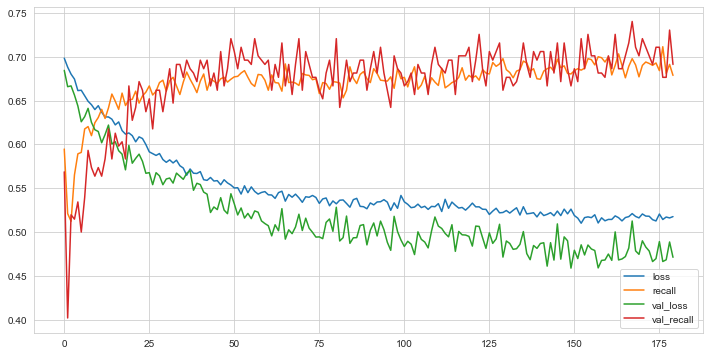

In [66]:
loss_df = pd.DataFrame(final_model.history.history)
loss_df.plot()

In [67]:
loss_df

,loss,recall,val_loss,val_recall
0,0.698,0.595,0.684,0.569
1,0.688,0.521,0.666,0.402
2,0.680,0.512,0.667,0.520
3,0.674,0.565,0.656,0.515
4,0.661,0.589,0.644,0.534
...,...,...,...,...
175,0.521,0.684,0.489,0.711
176,0.514,0.711,0.466,0.676
177,0.517,0.681,0.468,0.676
178,0.516,0.691,0.489,0.730


In [68]:
loss_df.nlargest(10, "val_recall")

,loss,recall,val_loss,val_recall
167,0.521,0.698,0.513,0.740
178,0.516,0.691,0.489,0.730
122,0.529,0.673,0.506,0.725
154,0.517,0.698,0.485,0.725
162,0.518,0.690,0.500,0.725
49,0.554,0.674,0.544,0.721
56,0.546,0.666,0.524,0.721
69,0.539,0.667,0.520,0.721
80,0.532,0.671,0.528,0.721
152,0.510,0.685,0.485,0.721


In [69]:
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[661 135]
 [ 63 141]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       796
           1       0.51      0.69      0.59       204

    accuracy                           0.80      1000
   macro avg       0.71      0.76      0.73      1000
weighted avg       0.83      0.80      0.81      1000



In [70]:
final_model.save('model_churn.h5')

### Prediction

In [71]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

CreditScore            619.000
Age                     42.000
Tenure                   2.000
Balance                  0.000
NumOfProducts            1.000
HasCrCard                1.000
IsActiveMember           1.000
EstimatedSalary     101348.880
customer_value           3.000
Geography_France         1.000
Geography_Germany        0.000
Geography_Spain          0.000
Gender_Female            1.000
Gender_Male              0.000
Name: 1, dtype: float64

In [72]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 14))
single_customer

array([[0.538     , 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 0.75      , 1.        ,
        0.        , 0.        , 1.        , 0.        ]])

In [73]:
(final_model.predict(single_customer) > 0.5).astype("int32")

array([[1]])

In [74]:
df["Exited"].iloc[0]

1

---
---

## Comparison with ML

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [100]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [101]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [102]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

In [103]:
grid_model_rf = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [104]:
grid_model_rf.best_params_

{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=250,
                        random_state=42),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 250}

In [105]:
grid_model_rf.best_score_

0.719587260463662

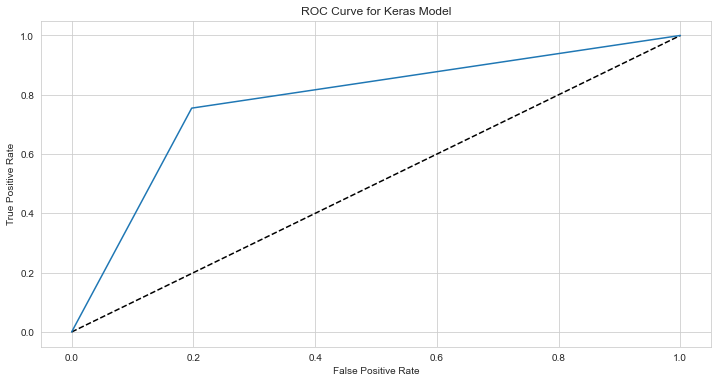

In [106]:
y_pred_proba = grid_model_rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [107]:
average_precision_score(y_test, y_pred_proba)

0.42380997415043187

In [108]:
y_test_pred = (grid_model_rf.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[639 157]
 [ 50 154]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.50      0.75      0.60       204

    accuracy                           0.79      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.79      0.81      1000



# SVC

In [109]:
pipeline = Pipeline([('classifier', clf2)])
params = [param1, param2, param3]

In [ ]:
grid_model_svc = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [ ]:
grid_model_svc.best_params_

In [ ]:
grid_model_svc.best_score_

In [ ]:
y_pred_proba = grid_model_svc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model_svc.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# LR

In [ ]:
pipeline = Pipeline([('classifier', clf3)])
params = [param1, param2, param3]

In [ ]:
grid_model_lr = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                          scoring='recall').fit(X_train, y_train)

In [ ]:
grid_model_lr.best_params_

In [ ]:
grid_model_lr.best_score_

In [ ]:
y_pred_proba = grid_model_lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Keras Model')
plt.show()

In [ ]:
average_precision_score(y_test, y_pred_proba)

In [ ]:
y_test_pred = (grid_model_lr.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

---
---